In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Градиентный спуск

In [2]:
# функция возвращает массив частных производных 
def gradient(f, x): # x - вектор
    h = 0.001
    derivative = []
    for i in range(len(x)):
        # считаем частные производные
        x_plus_h = np.hstack([x[:i], [x[i] + h], x[i + 1:]])
        x_minus_h = np.hstack([x[:i], [x[i] - h], x[i + 1:]])
        dfdxi = np.array((f(x_plus_h) - f(x_minus_h))/(2*h))
        derivative.append(dfdxi)
    return np.array(derivative)

# градиентный спуск с постоянным шагом
def gradient_descent_constant_step(x0, f, alpha, eps):# x0 - вектор
    x_min = [] # матрица
    x_min.append(np.array(x0))
    gradient_last = 0
    f_last = 0
    f_new = 0
    first_iteration = True
    steps_count = 0
    while first_iteration or ((f_last - f_new)/(np.linalg.norm(gradient_last)) > eps):
        x_last = np.array(x_min[len(x_min) - 1])
        gradient_last = gradient(f, x_last)
        x_new = x_last - alpha*gradient_last
        f_last = f(x_last)
        f_new = f(x_new)
        x_min.append(x_new)
        first_iteration = False
        steps_count += 1
    return [x_min, steps_count, 2*steps_count]

# градиентный спуск с дроблением шага
def gradient_descent_step_dividing(x0, f, alpha, λ, eps):# x0 - вектор
    x_min = [] # матрица
    x_min.append(np.array(x0))
    gradient_last = 0
    f_last = 0
    f_new = 0
    first_iteration = True
    func_count = 0
    steps_count = 0
    while first_iteration or ((f_last - f_new)/(np.linalg.norm(gradient_last)) > eps):
        x_last = np.array(x_min[len(x_min) - 1])
        gradient_last = gradient(f, x_last)
        f_last = f(x_last)

        x_new = x_last - alpha*gradient_last
        f_new = f(x_new)
        func_count += 2
        while f_last - f_new < eps*alpha*(np.linalg.norm(gradient_last))**2:
            alpha *= λ
            x_new = x_last - alpha*gradient_last
            f_new = f(x_new)
            func_count += 1
        x_min.append(x_new)
        first_iteration = False
        steps_count += 1
    return [x_min, steps_count, func_count]

# метод золотого сечения
def golden_ratio_method(f, a, b, eps):
  left, right = a, b
  # выполним первую итерацию перед циклом
  x2 = left + (right - left) * (5**0.5 - 1) / 2
  x1 = left + right - x2
  f1, f2 = f(x1), f(x2)
  func_count = 2
  while abs(right - left) > eps:
    if f1 < f2:
      right, x2, f2 = x2, x1, f1
      # x1 - вторая точка золотого сечения нового отрезка
     # ищем первую точку и вычисляем функцию в ней
      x1 = left + right - x2
      f1 = f(x1)
    if f1 >= f2:
      left, x1, f1 = x1, x2, f2
      # x2 - первая точка золотого сечения нового отрезка
      # ищем вторую точку и вычисляем функцию в ней
      x2 = left + right - x1
      f2 = f(x2)
    func_count += 1
  return (left + right)/2, func_count

# наискорейший спуск
def speedest_descent(x0, f, L, eps):# x0 - вектор
    x_min = [] # матрица
    x_min.append(np.array(x0))
    gradient_last = 0
    f_last = 0
    f_new = 0
    first_iteration = True
    steps_count = 0
    func_count = 0
    while first_iteration or ((f_last - f_new)/(np.linalg.norm(gradient_last)) > eps):
        x_last = np.array(x_min[len(x_min) - 1])
        gradient_last = gradient(f, x_last)
        f_last = f(x_last)
        func_count += 2
        phi = lambda alpha : f(x_last - alpha*gradient_last)
        alpha, count = golden_ratio_method(phi, 0, 2/L, eps)
        func_count += count
        x_new = x_last - alpha*gradient_last
        f_new = f(x_new)
        x_min.append(x_new)
        first_iteration = False
        steps_count += 1
    return [x_min, steps_count, func_count]
  
# метод сопряженных градиентов
def conjugate_gradient(x0, f, L, eps):
    x_min = [] # матрица
    x_min.append(np.array(x0))
    gradient_current = 0
    gradient_new = gradient(f, x0)
    d_new = -gradient_new
    d_current = 0
    f_current = 0
    f_new = f(x0)
    first_iteration = True
    steps_count = 1
    func_count = 1

    while first_iteration or ((f_current - f_new)/(np.linalg.norm(gradient_current)) > eps):
        x_current = np.array(x_min[len(x_min) - 1])
        d_current = d_new
        gradient_current = gradient_new
        f_current = f(x_current)

        phi = lambda alpha : f(x_current + alpha*d_current)
        alpha, count = golden_ratio_method(phi, 0, 2/L, eps)
        func_count += count + 2

        x_new = x_current + alpha*d_current
        gradient_new = gradient(f, x_new)
        steps_count += 1

        β = (gradient_new.dot(gradient_new )) / (gradient_current.dot(gradient_current))
        d_new = -gradient(f, x_new) + β*d_current
        f_new = f(x_new)
        
    
        x_min.append(x_new)
        first_iteration = False
    return [x_min, steps_count, func_count]

In [3]:
# функции - примеры
def f(x):
  return x[0]**2 + x[1]**2

def f2(x):
  return (x[0] - x[1])**2 + 10*(x[0]+5)**2

def f3(x):
    return -x[0]**2 + x[1]**2 + x[0] - x[1]

### Сравнение эффективности

In [53]:
def methods_efficacy(f, eps, alpha):
  constant_step = gradient_descent_constant_step([10, 6], f, alpha, eps)
  step_dividing = gradient_descent_step_dividing([10, 6], f, 5*alpha, 0.1, eps)
  speedest = speedest_descent([10, 6], f, 0.3, eps)
  conjugate = conjugate_gradient([10, 6], f, 0.3, eps)

  print("Вычисления градиента:")
  print("Спуск с постоянным шагом - ", constant_step[1])
  print("Спуск с дроблением шага - ", step_dividing[1])
  print("Наискорейший спуск - ", speedest[1])
  print("Сопряженные градиенты - ", conjugate[1])

  print("Вычисления функции:")
  print("Спуск с постоянным шагом - ", 2*constant_step[1])
  print("Спуск с дроблением шага - ", step_dividing[2])
  print("Наискорейший спуск - ", speedest[2])
  print("Сопряженные градиенты - ", conjugate[2])

In [20]:
methods_efficacy(f, 0.001, 0.5)

Вычисления градиента:
Спуск с постоянным шагом -  2
Спуск с дроблением шага -  2
Наискорейший спуск -  2
Сопряженные градиенты -  3
Вычисления функции:
Спуск с постоянным шагом -  4
Спуск с дроблением шага -  5
Наискорейший спуск -  36
Сопряженные градиенты -  37


In [39]:
methods_efficacy(f2, 0.001, 0.5)

Вычисления градиента:
Спуск с постоянным шагом -  1
Спуск с дроблением шага -  75
Наискорейший спуск -  7
Сопряженные градиенты -  7
Вычисления функции:
Спуск с постоянным шагом -  2
Спуск с дроблением шага -  151
Наискорейший спуск -  128
Сопряженные градиенты -  112


In [54]:
methods_efficacy(f3, 0.001, 0.5)

Вычисления градиента:
Спуск с постоянным шагом -  42
Спуск с дроблением шага -  17
Наискорейший спуск -  12
Сопряженные градиенты -  6
Вычисления функции:
Спуск с постоянным шагом -  84
Спуск с дроблением шага -  34
Наискорейший спуск -  276
Сопряженные градиенты -  116


C:\Users\Admin.COMPUTER\AppData\Local\Temp\ipykernel_18240\2578947041.py:22: RuntimeWarning: invalid value encountered in double_scalars
  while first_iteration or ((f_last - f_new)/(np.linalg.norm(gradient_last)) > eps):
C:\Users\Admin.COMPUTER\AppData\Local\Temp\ipykernel_18240\2578947041.py:43: RuntimeWarning: invalid value encountered in double_scalars
  while first_iteration or ((f_last - f_new)/(np.linalg.norm(gradient_last)) > eps):
C:\Users\Admin.COMPUTER\AppData\Local\Temp\ipykernel_18240\2578947041.py:95: RuntimeWarning: invalid value encountered in double_scalars
  while first_iteration or ((f_last - f_new)/(np.linalg.norm(gradient_last)) > eps):
C:\Users\Admin.COMPUTER\AppData\Local\Temp\ipykernel_18240\2578947041.py:138: RuntimeWarning: invalid value encountered in double_scalars
  β = (gradient_new.dot(gradient_new )) / (gradient_current.dot(gradient_current))
C:\Users\Admin.COMPUTER\AppData\Local\Temp\ipykernel_18240\2578947041.py:124: RuntimeWarning: invalid value encou

### Сходимость градиентного спуска с постоянным шагом

<ipython-input-46-82dcd50ac831>:22: RuntimeWarning: invalid value encountered in double_scalars
  while first_iteration or ((f_last - f_new)/(np.linalg.norm(gradient_last)) > eps):


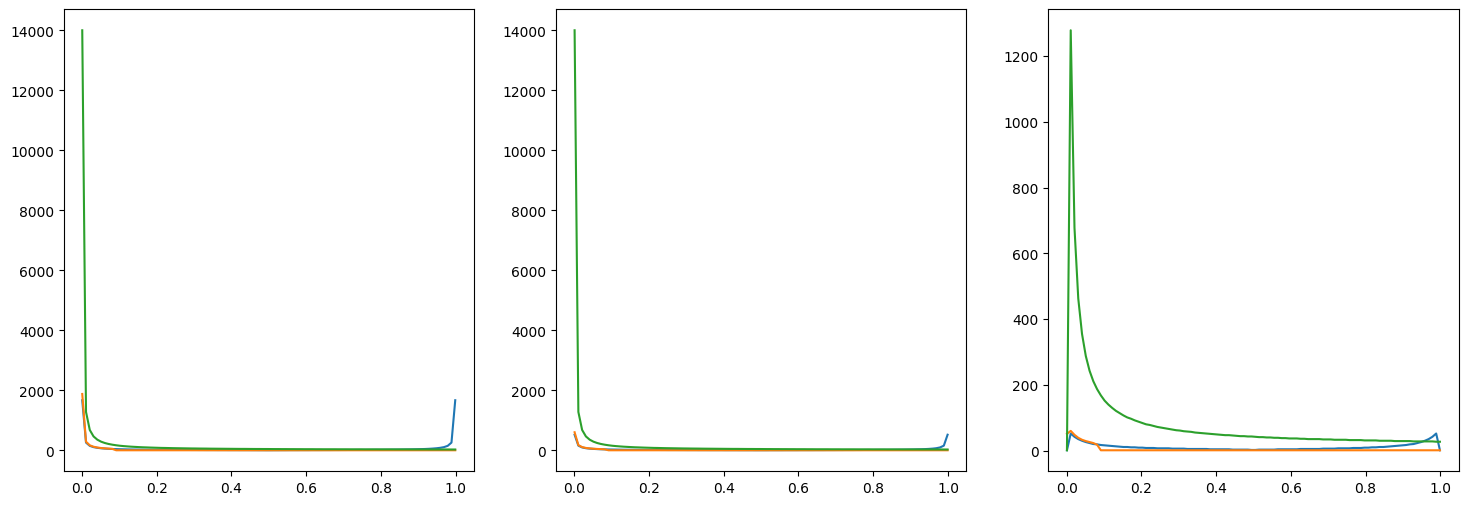

In [ ]:
alpha = np.linspace(0.001, 0.999, 100)

steps1 = [gradient_descent_constant_step([10, 10], f, alpha_, 0.001)[1] for alpha_ in alpha]
steps2 = [gradient_descent_constant_step([10, 10], f2, alpha_, 0.001)[1] for alpha_ in alpha]
steps3 = [gradient_descent_constant_step([10, 10], f3, alpha_, 0.001)[1] for alpha_ in alpha]

fig, ax = plt.subplots(nrows = 1, ncols = 3)
fig.set_figwidth(18)
fig.set_figheight(6)
ax[0].plot(alpha, steps1)
ax[0].plot(alpha, steps2)
ax[0].plot(alpha, steps3)

steps1 = [gradient_descent_constant_step([10, 10], f, alpha_, 0.01)[1] for alpha_ in alpha]
steps2 = [gradient_descent_constant_step([10, 10], f2, alpha_, 0.01)[1] for alpha_ in alpha]
steps3 = [gradient_descent_constant_step([10, 10], f3, alpha_, 0.01)[1] for alpha_ in alpha]

ax[1].plot(alpha, steps1)
ax[1].plot(alpha, steps2)
ax[1].plot(alpha, steps3)

steps1 = [gradient_descent_constant_step([10, 10], f, alpha_, 0.1)[1] for alpha_ in alpha]
steps2 = [gradient_descent_constant_step([10, 10], f2, alpha_, 0.1)[1] for alpha_ in alpha]
steps3 = [gradient_descent_constant_step([10, 10], f3, alpha_, 0.1)[1] for alpha_ in alpha]

ax[2].plot(alpha, steps1)
ax[2].plot(alpha, steps2)
ax[2].plot(alpha, steps3)

plt.savefig("constant_step")

### Зависимость от начальной точки

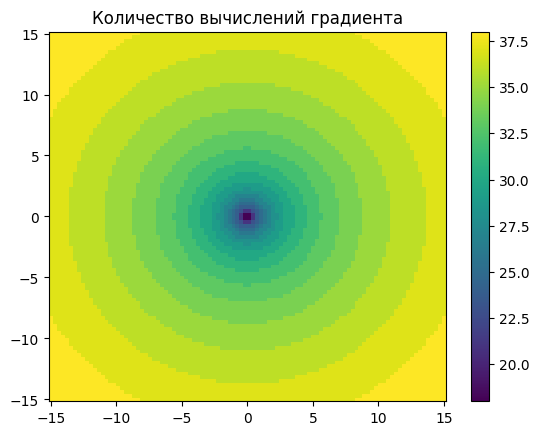

In [ ]:
def start_point_dependency(x_min):
  x = np.linspace (-15, 15, 100)
  y = np.linspace (-15, 15, 100)
  xgrid, ygrid = np.meshgrid(x, y)
  func_z = np.zeros((len(xgrid), len(xgrid)))
  gradient_z = np.zeros((len(xgrid), len(xgrid)))
  for i in range(len(xgrid)):
    for j in range(len(ygrid)):
      x_min_z = x_min(x[i], y[j])
      func_z[i][j] = x_min_z[2]
      gradient_z[i][j] = x_min_z[1]
  
  pict_1 = plt.pcolormesh(xgrid, ygrid, func_z, shading = 'auto')
  plt.colorbar(pict_1)
  plt.title("Количество вычислений функции")
  plt.savefig("func")
  plt.clf()

  pict_2 = plt.pcolormesh(xgrid, ygrid, gradient_z, shading = 'auto')
  plt.colorbar(pict_2)
  plt.title("Количество вычислений градиента")
  plt.savefig("grad")

constant_step = lambda x, y : gradient_descent_constant_step([x, y], f, 0.1, 0.001)
step_dividing = lambda x, y : gradient_descent_step_dividing([x, y], f, 0.1, 0.001)
speedest = lambda x, y : speedest_descent([x, y], f, 5, 0.001)
conjugate = lambda x, y : conjugate_gradient([x, y], f, 5, 0.001)

start_point_dependency(constant_step)

### Линии уровней и траектории

In [ ]:
def draw(xmin, f, title_name):
  x = np.linspace (-30, 30, 100)
  y = np.linspace (-30, 30, 100)
  xgrid, ygrid = np.meshgrid(x, y)
  z = f([xgrid, ygrid])

  fig = plt.figure()
  fig.set_figwidth(6)
  fig.set_figheight(6)

  axes = fig.add_subplot(projection='3d')
  axes.plot_surface( xgrid,ygrid, z, color = "green")
  plt.savefig("3d")

  fig, ax = plt.subplots()
  points = np.asarray(xmin).reshape(-1, 2)
  ax.plot(points[:, 0], points[:, 1] , 'o-')
  ax.contour(xgrid, ygrid, f(np.array([xgrid, ygrid])), levels=np.unique(sorted([f(np.array([p[0], p[1]])) for p in points])))
  ax.set_title(title_name)
  plt.savefig("lines")

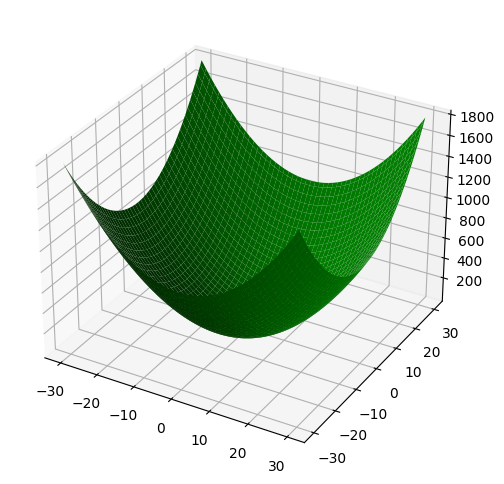

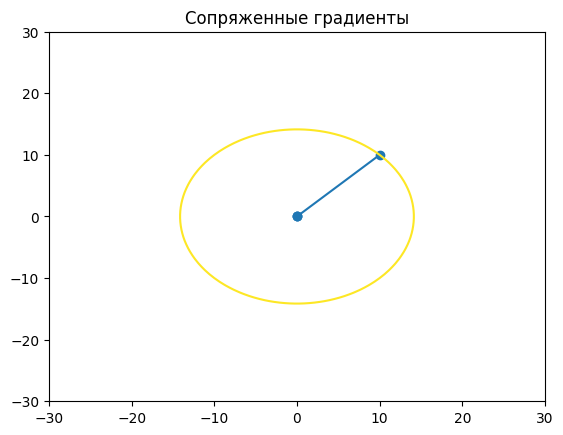

In [ ]:
#draw(gradient_descent_constant_step([10, 10], f, 0.1, 0.001)[0], f, "Спуск с постоянным шагом")
draw(gradient_descent_step_dividing([10, 10], f, 2, 0.5, 0.001)[0], f, "Спуск с дроблением шага")
#draw(speedest_descent([10, 10], f, 2, 0.001)[0], f, "Наискорейший спуск")
#draw(conjugate_gradient([10, 10], f, 2, 0.001)[0], f, "Сопряженные градиенты")

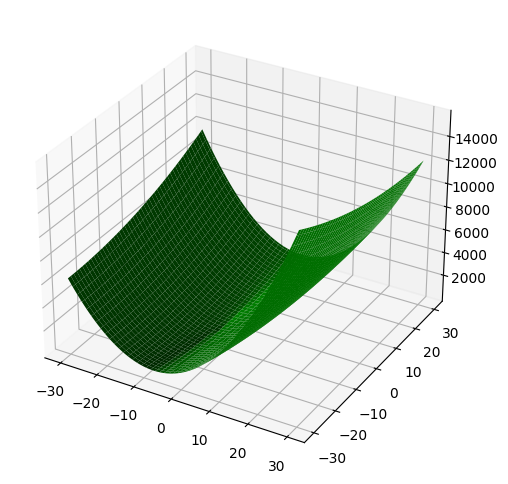

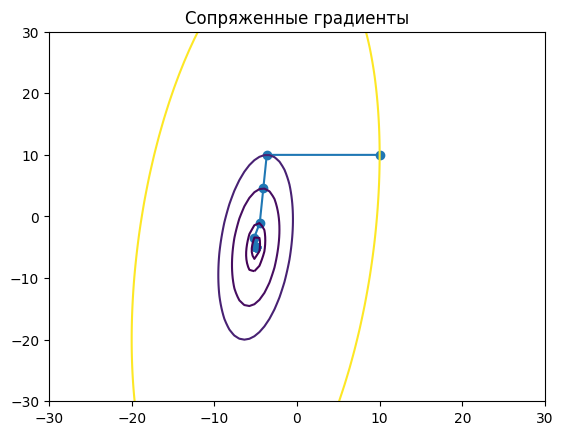

In [ ]:
#draw(gradient_descent_constant_step([10, 10], f2, 0.08, 0.001)[0], f2, "Спуск с постоянным шагом")
#draw(gradient_descent_step_dividing([10, 10], f2, 0.08, 0.01, 0.001)[0], f2, "Спуск с дроблением шага")
#draw(gradient_descent_step_dividing([10, 10], f2, 0.1, 0.1, 0.5)[0], f2, "Спуск с дроблением шага, ε = 0.5")
#draw(speedest_descent([10, 10], f2, 2, 0.001)[0], f2, "Наискорейший спуск")
draw(conjugate_gradient([10, 10], f2, 10, 0.001)[0], f2, "Cопряженные градиенты")

<ipython-input-46-82dcd50ac831>:138: RuntimeWarning: invalid value encountered in double_scalars
  β = (gradient_new.dot(gradient_new )) / (gradient_current.dot(gradient_current))
<ipython-input-46-82dcd50ac831>:124: RuntimeWarning: invalid value encountered in double_scalars
  while first_iteration or ((f_current - f_new)/(np.linalg.norm(gradient_current)) > eps):


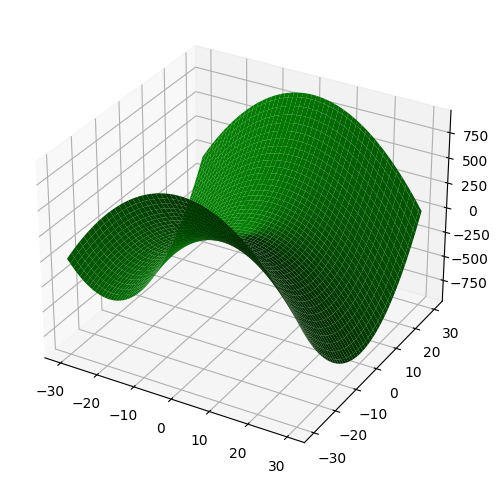

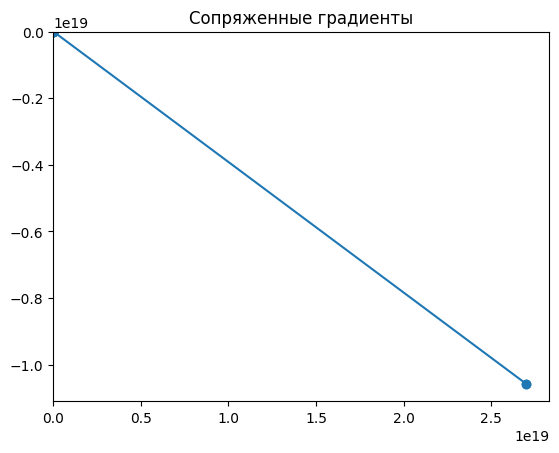

In [ ]:
#draw(gradient_descent_constant_step([10, 10], f3, 0.1, 0.001)[0], f3, "Спуск с постоянным шагом")
#draw(gradient_descent_step_dividing([10, 10], f3, 0.1, 0.1, 0.2)[0], f3, "Спуск с дроблением шага, ε = 0.2")
#draw(speedest_descent([1, 1], f3, 2, 0.7)[0], f3, "Наискорейший спуск, ε = 0.7")
draw(conjugate_gradient([10, 10], f3, 3, 0.01)[0], f3, "Cопряженные градиенты")

### Генератор квадратичных функций

In [ ]:
def generator_random_square_function(n, k):
    diagonal = []
    diagonal.append(1)
    for i in range(2, n):
        diagonal.append(np.random.uniform(1, k))
    diagonal.append(k)    
    A = np.diag(diagonal)
    b = np.random.randn(n)
    
    return lambda x: 0.5*np.dot(x.T, np.dot(A, x)) + np.dot(b.T, x)

In [ ]:
def draw_dependency():
  k = np.linspace(1, 1000, 49, dtype = int)
  n = np.linspace(2, 1001, 49, dtype = int)
  kgrid, ngrid = np.meshgrid(k, n)
  T = np.zeros((len(kgrid), len(ngrid)))
  for i in range(len(kgrid)):
    for j in range(len(ngrid)):
       n[i] = int(n[i])
       k[j] = int(k[j])
       f = generator_random_square_function(n[i], k[j])
       x0 = np.random.randn(n[i]) * k[j]/2
       a = gradient_descent_constant_step(x0, f, 1/k[j], 0.0005)
       T[i][j] = a[1]
       print(a[1], n[i], k[j])
  pict_1 = plt.pcolormesh(ngrid, kgrid, T, shading = 'auto')
  plt.colorbar(pict_1)
  plt.title("Количество вычислений функции")

In [ ]:
draw_dependency()